In [ ]:
import os
import json
import pandas as pd
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_generations_per_run(directory_path):
    """
    Analyzes JSONL files and calculates the sum of generations per run_id.
    
    Args:
        directory_path (str): Path to directory containing JSONL files
        
    Returns:
        pd.DataFrame: DataFrame with run_id and generation counts
    """
    
    # Dictionary to store generation counts per run_id
    generation_counts = defaultdict(int)
    
    # Find all JSONL files
    jsonl_files = list(Path(directory_path).glob("*.jsonl"))
    
    print(f"Found {len(jsonl_files)} JSONL files")
    
    for file_path in jsonl_files:
        print(f"Processing: {file_path.name}")
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            
            # Process Line 3: User Imitations (0-indexed, so line 2)
            if len(lines) > 2:
                try:
                    imitations_data = json.loads(lines[2].strip())
                    
                    if 'runs' in imitations_data:
                        for run in imitations_data['runs']:
                            if 'persona' in run and 'imitations' in run:
                                # Extract run_id from persona or use a default pattern
                                persona = run['persona']
                                num_imitations = len(run['imitations'])
                                
                                # Try to extract run_id from persona description
                                # Assuming persona contains run information
                                run_id = f"imitations_{file_path.stem}"
                                generation_counts[run_id] += num_imitations
                                
                except json.JSONDecodeError as e:
                    print(f"  Error parsing imitations in {file_path.name}: {e}")
            
            # Process Line 4: Evaluation Results (0-indexed, so line 3)
            if len(lines) > 3:
                try:
                    eval_data = json.loads(lines[3].strip())
                    
                    if 'evaluations' in eval_data:
                        for evaluation in eval_data['evaluations']:
                            run_id = evaluation.get('run_id', 'unknown')
                            
                            if 'evaluation_results' in evaluation:
                                eval_results = evaluation['evaluation_results']
                                
                                # Count from individual_scores
                                if 'individual_scores' in eval_results:
                                    num_generations = len(eval_results['individual_scores'])
                                    generation_counts[run_id] += num_generations
                                
                                # Also count from best_predictions and worst_predictions if available
                                for key in ['best_predictions', 'worst_predictions']:
                                    if key in eval_results and eval_results[key]:
                                        # These are subsets, so don't double count
                                        pass
                                
                except json.JSONDecodeError as e:
                    print(f"  Error parsing evaluations in {file_path.name}: {e}")
                    
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
    
    # Convert to DataFrame
    df = pd.DataFrame([
        {'run_id': run_id, 'total_generations': count}
        for run_id, count in generation_counts.items()
    ]).sort_values('total_generations', ascending=False)
    
    return df

def visualize_generation_counts(df, top_n=20):
    """
    Creates visualizations of generation counts per run_id.
    
    Args:
        df (pd.DataFrame): DataFrame with run_id and generation counts
        top_n (int): Number of top runs to show in bar plot
    """
    
    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Top N runs bar plot
    top_runs = df.head(top_n)
    axes[0, 0].barh(range(len(top_runs)), top_runs['total_generations'])
    axes[0, 0].set_yticks(range(len(top_runs)))
    axes[0, 0].set_yticklabels([rid[:30] + '...' if len(rid) > 30 else rid 
                               for rid in top_runs['run_id']], fontsize=8)
    axes[0, 0].set_xlabel('Total Generations')
    axes[0, 0].set_title(f'Top {top_n} Runs by Generation Count')
    axes[0, 0].invert_yaxis()
    
    # 2. Distribution histogram
    axes[0, 1].hist(df['total_generations'], bins=30, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Total Generations')
    axes[0, 1].set_ylabel('Number of Runs')
    axes[0, 1].set_title('Distribution of Generation Counts')
    
    # 3. Summary statistics
    axes[1, 0].axis('off')
    stats_text = f"""
    Summary Statistics:
    
    Total Runs: {len(df)}
    Total Generations: {df['total_generations'].sum():,}
    
    Mean Generations per Run: {df['total_generations'].mean():.1f}
    Median Generations per Run: {df['total_generations'].median():.1f}
    Std Dev: {df['total_generations'].std():.1f}
    
    Min Generations: {df['total_generations'].min()}
    Max Generations: {df['total_generations'].max()}
    
    Runs with 0 generations: {(df['total_generations'] == 0).sum()}
    Runs with 50+ generations: {(df['total_generations'] >= 50).sum()}
    """
    axes[1, 0].text(0.1, 0.9, stats_text, transform=axes[1, 0].transAxes, 
                    fontsize=11, verticalalignment='top', fontfamily='monospace')
    
    # 4. Run type analysis (if run_ids follow pattern)
    run_types = df['run_id'].str.extract(r'(bleu_only|perplexity_only|all_metrics|rouge_only)')
    run_types_counts = run_types[0].value_counts()
    
    if not run_types_counts.empty:
        axes[1, 1].pie(run_types_counts.values, labels=run_types_counts.index, autopct='%1.1f%%')
        axes[1, 1].set_title('Distribution by Run Type')
    else:
        axes[1, 1].axis('off')
        axes[1, 1].text(0.5, 0.5, 'No recognizable run type patterns found', 
                        ha='center', va='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.show()

def analyze_by_run_type(df):
    """
    Analyzes generation counts grouped by run type.
    
    Args:
        df (pd.DataFrame): DataFrame with run_id and generation counts
        
    Returns:
        pd.DataFrame: Summary statistics by run type
    """
    
    # Extract run type from run_id
    df_copy = df.copy()
    
    # Try to extract different patterns
    patterns = {
        'bleu_only': r'bleu_only',
        'perplexity_only': r'perplexity_only', 
        'all_metrics': r'all_metrics',
        'rouge_only': r'rouge_only',
        'imitations': r'imitations'
    }
    
    df_copy['run_type'] = 'other'
    
    for run_type, pattern in patterns.items():
        mask = df_copy['run_id'].str.contains(pattern, na=False)
        df_copy.loc[mask, 'run_type'] = run_type
    
    # Group by run type and calculate statistics
    summary = df_copy.groupby('run_type')['total_generations'].agg([
        'count', 'sum', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    
    summary.columns = ['Num_Runs', 'Total_Gens', 'Mean_Gens', 'Median_Gens', 'Std_Gens', 'Min_Gens', 'Max_Gens']
    
    return summary.sort_values('Total_Gens', ascending=False)

# Main execution
def main():
    # Set your directory path here
    DIRECTORY_PATH = "data/restore"  # Update this path
    
    print("=" * 60)
    print("GENERATION COUNT ANALYZER")
    print("=" * 60)
    
    # Analyze generation counts
    df = analyze_generations_per_run(DIRECTORY_PATH)
    
    print(f"\nFound {len(df)} unique run_ids")
    print(f"Total generations across all runs: {df['total_generations'].sum():,}")
    
    # Display top runs
    print("\nTop 10 Runs by Generation Count:")
    print(df.head(10).to_string(index=False))
    
    # Analyze by run type
    if len(df) > 0:
        print("\nAnalysis by Run Type:")
        type_summary = analyze_by_run_type(df)
        print(type_summary)
        
        # Create visualizations
        visualize_generation_counts(df)
        
        return df, type_summary
    else:
        print("No data found to analyze.")
        return None, None

# If running in Jupyter, you can also call individual functions:
def quick_analysis(directory_path):
    """Quick analysis function for Jupyter cells"""
    df = analyze_generations_per_run(directory_path)
    print(f"Total runs: {len(df)}")
    print(f"Total generations: {df['total_generations'].sum():,}")
    print(f"Average generations per run: {df['total_generations'].mean():.1f}")
    return df

# Example usage in Jupyter:
# df = quick_analysis("/path/to/your/data")
# df.head(20)  # Show top 20 runs

GENERATION COUNT ANALYZER
Found 25 JSONL files
Processing: 1.1782932009073132e+18.jsonl
Processing: 17813513.0.jsonl
Processing: 1.4204222245914296e+18.jsonl
Processing: 302225782.0.jsonl
Processing: 1.0679687024008764e+18.jsonl
Processing: 38283342.0.jsonl
Processing: 1390669327.0.jsonl
Processing: 1.4045329932266865e+18.jsonl
Processing: 1.063839405977338e+18.jsonl
Processing: 1.168793622248067e+18.jsonl
Processing: 1.05272263315268e+18.jsonl
Processing: 527526077.0.jsonl
Processing: 409824643.0.jsonl
Processing: 1362828098.0.jsonl
Processing: 8.840833612953354e+17.jsonl
Processing: 3225632674.0.jsonl
Processing: 16862150.0.jsonl
Processing: 157516153.0.jsonl
Processing: 1.470492384274309e+18.jsonl
Processing: 3138390312.0.jsonl
Processing: 2570955294.0.jsonl
Processing: 1.5743066908578488e+18.jsonl
Processing: 182179968.0.jsonl
Processing: 1.2133059545208463e+18.jsonl
Processing: 1.26461714332638e+18.jsonl

Found 523 unique run_ids
Total generations across all runs: 64,138

Top 10 R

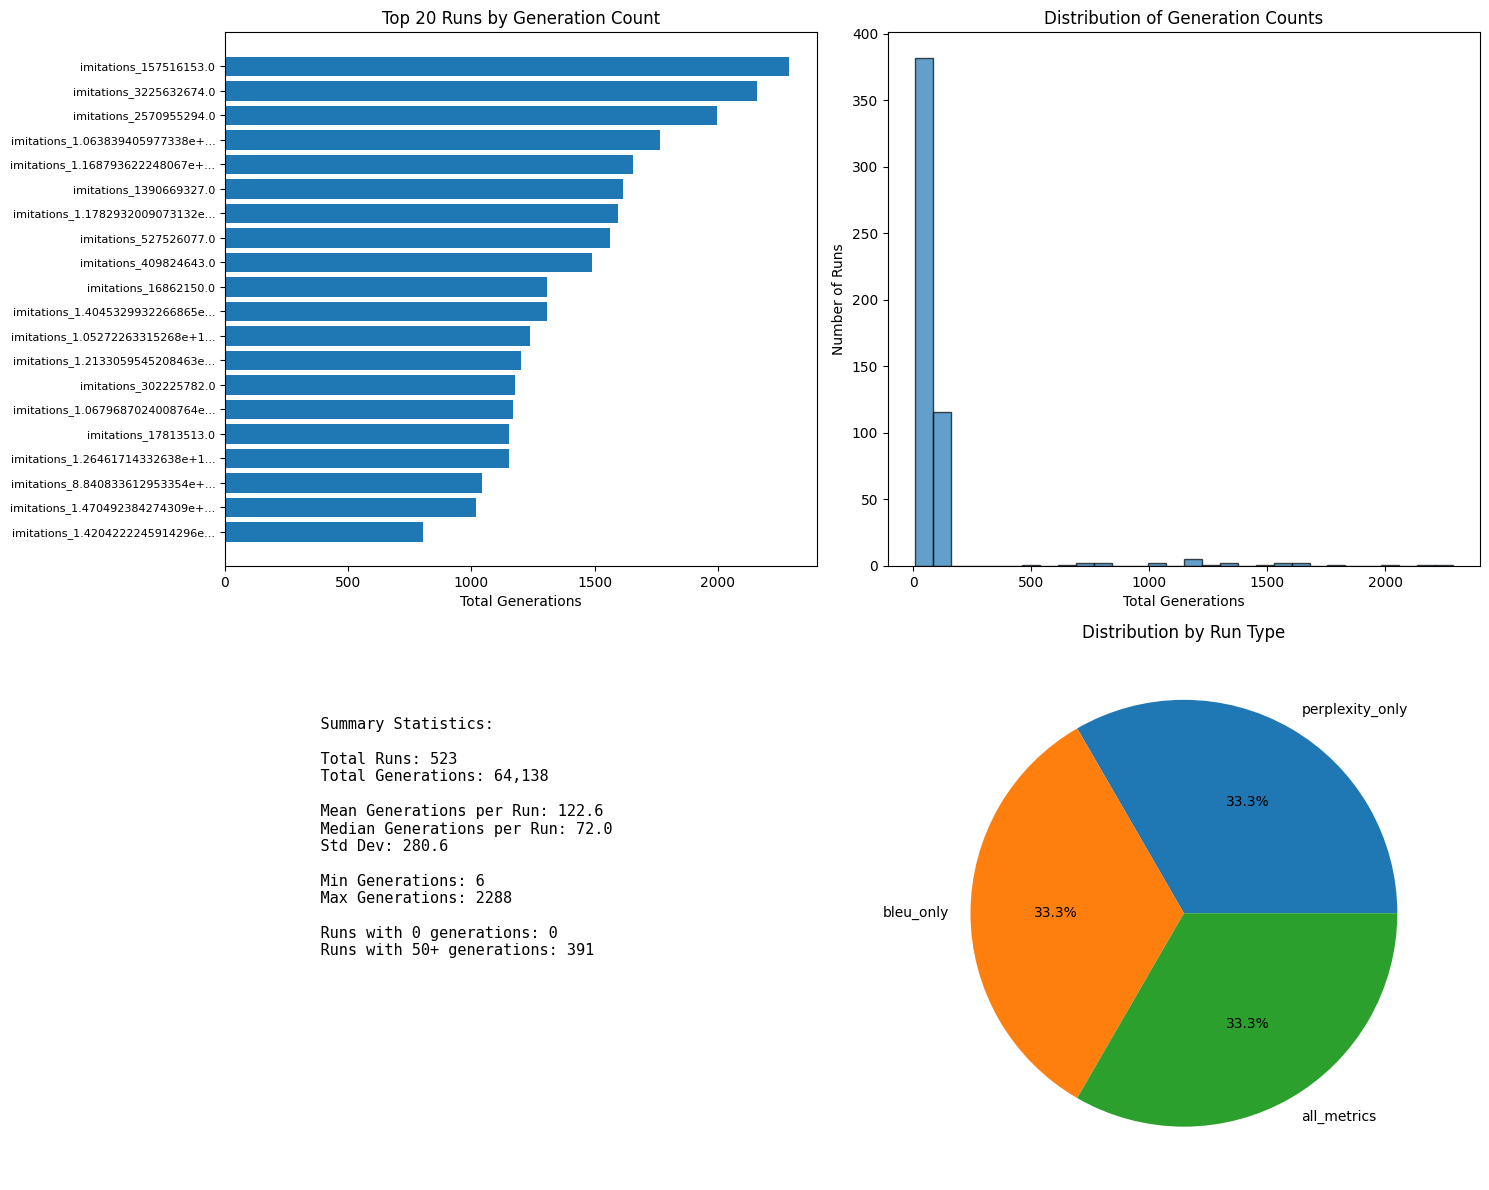

(                               run_id  total_generations
 515            imitations_157516153.0               2288
 513           imitations_3225632674.0               2160
 518           imitations_2570955294.0               1998
 482  imitations_1.063839405977338e+18               1764
 507  imitations_1.168793622248067e+18               1656
 ..                                ...                ...
 494          2025_07_16_mac3_round_12                 12
 495          2025_07_16_mac3_round_13                 12
 315      run_r50_all_metrics_round_32                 12
 481              test_run_mac_round_2                  6
 480              test_run_mac_round_1                  6
 
 [523 rows x 2 columns],
                  Num_Runs  Total_Gens  Mean_Gens  Median_Gens  Std_Gens  \
 run_type                                                                  
 imitations             25       32084    1283.36       1200.0    469.61   
 other                 348       21764      62.54

In [3]:
main()

## Overview

In [6]:
import os
import json
import pandas as pd
from pathlib import Path
import re

def get_run_id_overview(directory_path):
    """
    Creates a simple overview of all run_ids with their rounds and generations.
    
    Args:
        directory_path (str): Path to directory containing JSONL files
        
    Returns:
        pd.DataFrame: DataFrame with run_id, rounds, and generations_per_run
    """
    
    run_data = []
    
    # Find all JSONL files
    jsonl_files = list(Path(directory_path).glob("*.jsonl"))
    
    print(f"Found {len(jsonl_files)} JSONL files")
    
    for file_path in jsonl_files:
        print(f"Processing: {file_path.name}")
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            
            # Process Line 4: Evaluation Results (0-indexed, so line 3)
            if len(lines) > 3:
                try:
                    eval_data = json.loads(lines[3].strip())
                    
                    if 'evaluations' in eval_data:
                        for evaluation in eval_data['evaluations']:
                            run_id = evaluation.get('run_id', 'unknown')
                            
                            if 'evaluation_results' in evaluation:
                                eval_results = evaluation['evaluation_results']
                                
                                # Count generations from individual_scores
                                generations = 0
                                if 'individual_scores' in eval_results:
                                    generations = len(eval_results['individual_scores'])
                                
                                # Extract rounds information from run_id
                                rounds = 1  # Default to 1 round if not specified
                                
                                # Try to extract rounds from run_id pattern (e.g. "round_15" → 15)
                                round_match = re.search(r'round_(\d+)', run_id)
                                if round_match:
                                    rounds = int(round_match.group(1))
                                
                                # Also try to extract from evaluation data if available
                                if 'rounds' in evaluation:
                                    rounds = evaluation['rounds']
                                elif 'num_rounds' in evaluation:
                                    rounds = evaluation['num_rounds']
                                
                                run_data.append({
                                    'run_id': run_id,
                                    'rounds': rounds,
                                    'generations_per_run': generations
                                })
                                
                except json.JSONDecodeError as e:
                    print(f"  Error parsing evaluations in {file_path.name}: {e}")
                    
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
    
    # Convert to DataFrame and remove duplicates (keep the one with highest generations)
    if run_data:
        df = pd.DataFrame(run_data)
        # Group by run_id and take the entry with max generations (in case of duplicates)
        df = df.loc[df.groupby('run_id')['generations_per_run'].idxmax()]
        df = df.sort_values(['run_id'])
        df = df.reset_index(drop=True)
        return df
    else:
        return pd.DataFrame(columns=['run_id', 'rounds', 'generations_per_run'])

def display_overview(directory_path, group_by_type=True):
    """
    Display a simple overview of all run_ids.
    
    Args:
        directory_path (str): Path to directory containing JSONL files
        group_by_type (bool): Whether to group runs by type for better overview
    """
    
    print("=" * 70)
    print("RUN ID OVERVIEW")
    print("=" * 70)
    
    df = get_run_id_overview(directory_path)
    
    if len(df) > 0:
        print(f"\nFound {len(df)} unique run_ids:\n")
        
        if group_by_type:
            # Group runs by base name (without round_X suffix)
            df_copy = df.copy()
            
            # Extract base run name (everything before _round_X)
            df_copy['base_run_name'] = df_copy['run_id'].str.replace(r'_round_\d+$', '', regex=True)
            
            # Group by base run name
            grouped = df_copy.groupby('base_run_name').agg({
                'rounds': ['min', 'max', 'count'],
                'generations_per_run': ['first', 'sum'],
                'run_id': 'count'
            }).round(2)
            
            # Flatten column names
            grouped.columns = ['min_round', 'max_round', 'num_runs', 'gens_per_run', 'total_gens', 'run_count']
            
            # Sort by total generations (descending)
            grouped = grouped.sort_values('total_gens', ascending=False)
            
            print(f"\nGROUPED BY BASE RUN NAME:")
            print(f"{'Base Run Name':<50} | {'Rounds':<12} | {'Runs':<5} | {'Gens Each':<9} | {'Total Gens':<10}")
            print("-" * 100)
            
            for base_name, row in grouped.iterrows():
                # Truncate long names
                display_name = base_name if len(base_name) <= 47 else base_name[:44] + "..."
                
                # Format round range
                if row['min_round'] == row['max_round']:
                    round_info = f"{int(row['min_round'])}"
                else:
                    round_info = f"{int(row['min_round'])}-{int(row['max_round'])}"
                
                print(f"{display_name:<50} | {round_info:<12} | {int(row['num_runs']):<5} | {int(row['gens_per_run']):<9} | {int(row['total_gens']):<10}")
            
        else:
            # Original detailed view
            print(f"{'Run_ID':<40} | {'Rounds':<6} | {'Generations':<11}")
            print("-" * 70)
            
            for _, row in df.iterrows():
                run_id = row['run_id']
                if len(run_id) > 37:
                    run_id = run_id[:34] + "..."
                
                print(f"{run_id:<40} | {row['rounds']:<6} | {row['generations_per_run']:<11}")
        
        # Summary statistics
        print("\n" + "=" * 70)
        print("SUMMARY:")
        print(f"Total Run IDs: {len(df)}")
        print(f"Total Generations: {df['generations_per_run'].sum():,}")
        print(f"Average Generations per Run: {df['generations_per_run'].mean():.1f}")
        print(f"Min Generations: {df['generations_per_run'].min()}")
        print(f"Max Generations: {df['generations_per_run'].max()}")
        
        # Quick breakdown by generation count
        gen_counts = df['generations_per_run'].value_counts().sort_index()
        print(f"\nGeneration Distribution:")
        for gen_count, num_runs in gen_counts.items():
            print(f"  {gen_count} generations: {num_runs} runs")
        
        return df
    else:
        print("No run_ids found in the specified directory.")
        return None

# Main function
def main():
    # Set your directory path here
    DIRECTORY_PATH = "data/restore"  # Update this path
    
    df = display_overview(DIRECTORY_PATH)
    return df

# Quick function for interactive use
def quick_overview(directory_path):
    """Quick function to get overview DataFrame"""
    return get_run_id_overview(directory_path)

# Example usage:
if __name__ == "__main__":
    # Run the main function
    df = main()
    
    # You can also save to CSV if needed
    if df is not None:
        # df.to_csv('run_id_overview.csv', index=False)
        pass

RUN ID OVERVIEW
Found 25 JSONL files
Processing: 1.1782932009073132e+18.jsonl
Processing: 17813513.0.jsonl
Processing: 1.4204222245914296e+18.jsonl
Processing: 302225782.0.jsonl
Processing: 1.0679687024008764e+18.jsonl
Processing: 38283342.0.jsonl
Processing: 1390669327.0.jsonl
Processing: 1.4045329932266865e+18.jsonl
Processing: 1.063839405977338e+18.jsonl
Processing: 1.168793622248067e+18.jsonl
Processing: 1.05272263315268e+18.jsonl
Processing: 527526077.0.jsonl
Processing: 409824643.0.jsonl
Processing: 1362828098.0.jsonl
Processing: 8.840833612953354e+17.jsonl
Processing: 3225632674.0.jsonl
Processing: 16862150.0.jsonl
Processing: 157516153.0.jsonl
Processing: 1.470492384274309e+18.jsonl
Processing: 3138390312.0.jsonl
Processing: 2570955294.0.jsonl
Processing: 1.5743066908578488e+18.jsonl
Processing: 182179968.0.jsonl
Processing: 1.2133059545208463e+18.jsonl
Processing: 1.26461714332638e+18.jsonl

Found 498 unique run_ids:


GROUPED BY BASE RUN NAME:
Base Run Name                   

In [10]:
def find_run_ids_fixed(users_directory, prefix):
    """Find all run_ids in the user files that start with a given prefix.
    
    Updated to check all lines and all possible data structures.
    """
    run_ids = set()
    if not os.path.isdir(users_directory):
        print(f"Error: Directory not found at {users_directory}")
        return []
    
    user_files = [f for f in os.listdir(users_directory) if f.endswith('.jsonl')]
    
    for user_file in user_files:
        user_file_path = os.path.join(users_directory, user_file)
        try:
            with open(user_file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                
                # Check all lines, not just line 3
                for line_num, line in enumerate(lines):
                    try:
                        data = json.loads(line)
                        
                        # Check different possible structures
                        
                        # 1. Original structure: 'runs' key (line 3)
                        if 'runs' in data:
                            for run in data.get('runs', []):
                                run_id = run.get('run_id')
                                if run_id and run_id.startswith(prefix):
                                    run_ids.add(run_id)
                        
                        # 2. New structure: 'evaluations' key (line 4)
                        if 'evaluations' in data:
                            for eval_item in data.get('evaluations', []):
                                # The run_id might be directly in the evaluation item
                                # or nested within it
                                run_id = eval_item.get('run_id')
                                if run_id and run_id.startswith(prefix):
                                    run_ids.add(run_id)
                                
                                # Check if run_id is nested deeper
                                if isinstance(eval_item, dict):
                                    for key, value in eval_item.items():
                                        if key == 'run_id' and isinstance(value, str) and value.startswith(prefix):
                                            run_ids.add(value)
                        
                        # 3. Check any other list structures that might contain run_ids
                        for key, value in data.items():
                            if isinstance(value, list):
                                for item in value:
                                    if isinstance(item, dict) and 'run_id' in item:
                                        run_id = item.get('run_id')
                                        if run_id and run_id.startswith(prefix):
                                            run_ids.add(run_id)
                                            
                    except json.JSONDecodeError:
                        continue
                        
        except (FileNotFoundError, IOError):
            continue
    
    return sorted(list(run_ids))

# Test the fixed function
print("Testing fixed function:")
bleu_ids = find_run_ids_fixed("data/restore", "run_r50_bleu_only")
perp_ids = find_run_ids_fixed("data/restore", "run_r50_perplexity_only")

print(f"Found {len(bleu_ids)} bleu_only runs")
print(f"Found {len(perp_ids)} perplexity_only runs")

if bleu_ids:
    print(f"Sample bleu IDs: {bleu_ids[:5]}")
if perp_ids:
    print(f"Sample perplexity IDs: {perp_ids[:5]}")

Testing fixed function:
Found 50 bleu_only runs
Found 50 perplexity_only runs
Sample bleu IDs: ['run_r50_bleu_only_round_1', 'run_r50_bleu_only_round_10', 'run_r50_bleu_only_round_11', 'run_r50_bleu_only_round_12', 'run_r50_bleu_only_round_13']
Sample perplexity IDs: ['run_r50_perplexity_only_round_1', 'run_r50_perplexity_only_round_10', 'run_r50_perplexity_only_round_11', 'run_r50_perplexity_only_round_12', 'run_r50_perplexity_only_round_13']


In [11]:
import json
from collections import defaultdict

def analyze_json_structure(data_object, schema_map):
    """
    Recursively analyzes the structure of a Python object (from JSON)
    and updates the schema_map with keys and data types.

    :param data_object: The data object (dict, list, primitive) to analyze.
    :param schema_map: The dictionary accumulating the schema information.
    """
    # Case 1: JSON Object (Python Dictionary)
    if isinstance(data_object, dict):
        for key, value in data_object.items():
            # Ensure a sub-dictionary exists for this key to store its structure/types.
            # Use setdefault to create an empty dict if key doesn't exist.
            sub_schema = schema_map.setdefault(key, {})
            analyze_json_structure(value, sub_schema)

    # Case 2: JSON Array (Python List)
    elif isinstance(data_object, list):
        # Use a special key "[items]" to represent elements within an array.
        sub_schema = schema_map.setdefault("[items]", {})
        # Analyze each item in the list, merging their structures.
        for item in data_object:
            analyze_json_structure(item, sub_schema)

    # Case 3: Primitive Value (str, int, float, bool, None)
    else:
        # Record the type of the primitive value in a set under '<types>'.
        # Using setdefault ensures we create the set on first encounter.
        type_set = schema_map.setdefault("<types>", set())
        type_set.add(type(data_object).__name__)

def clean_schema_representation(schema_map):
    """
    Cleans the generated schema map for more readable output.
    Converts sets of types into sorted strings and simplifies node structure.
    """
    clean_view = {}
    for key, value in schema_map.items():
        if isinstance(value, dict):
            # Check if this node contains type information directly
            if "<types>" in value:
                # Format type information: sort types for consistent output
                type_str = " | ".join(sorted(list(value["<types>"])))
                
                # Check for nested structures (e.g., a list containing objects)
                nested_structure = {k: clean_schema_representation(v) for k, v in value.items() if k != "<types>"}
                
                if nested_structure:
                    # Special handling for list items to keep the structure clean
                    if key == "[items]":
                        nested_structure["<element_types>"] = type_str
                        clean_view[key] = nested_structure
                    else:
                        # Case where a key holds both primitive types and object structures (rare)
                        clean_view[key] = {"<types>": type_str, **nested_structure}
                else:
                    # Pure primitive type leaf node
                    clean_view[key] = type_str
            else:
                # Purely structural node (no direct primitive types), recurse deeper
                clean_view[key] = clean_schema_representation(value)
    return clean_view

def get_jsonl_structure(filepath):
    """
    Reads a JSONL file line by line and aggregates the structure.

    :param filepath: Path to the .jsonl file.
    :return: A dictionary representing the aggregated schema.
    """
    master_schema = {}
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                line = line.strip()
                if not line:
                    continue
                
                try:
                    json_record = json.loads(line)
                    analyze_json_structure(json_record, master_schema)
                except json.JSONDecodeError:
                    print(f"Warning: Skipping malformed JSON on line {i + 1}")

    except FileNotFoundError:
        print(f"Error: File not found at path: {filepath}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

    return clean_schema_representation(master_schema)


# --- Configuration ---
filepath = "data/restore/1.063839405977338e+18.jsonl"  # <--- Change this to your file path

# --- Run Analysis ---
structure = get_jsonl_structure(filepath)

# --- Display Result ---
structure

{'user_id': 'str',
 'set': 'str',
 'tweets': {'[items]': {'full_text': 'str',
   'tweet_id': 'str',
   'created_at': 'str',
   'screen_name': 'str',
   'original_user_id': 'str',
   'retweeted_user_ID': 'float',
   'collected_at': 'str',
   'reply_to_id': 'NoneType | str',
   'reply_to_user': 'float',
   'expandedURL': 'str',
   'previous_message': 'NoneType | str',
   'masked_text': 'str'}},
 'runs': {'[items]': {'run_id': 'str',
   'persona': 'str',
   'imitations': {'[items]': {'tweet_id': 'str',
     'stimulus': 'str',
     'imitation': 'str',
     'original': 'str'}}}},
 'evaluations': {'[items]': {'run_id': 'str',
   'timestamp': 'str',
   'evaluation_results': {'overall': {'rouge': {'rouge1': 'float',
      'rouge2': 'float',
      'rougeL': 'float',
      'rougeLsum': 'float'},
     'bleu': {'bleu': 'float',
      'precisions': {'[items]': 'float'},
      'brevity_penalty': 'float',
      'length_ratio': 'float',
      'translation_length': 'int',
      'reference_length': 'int